<a href="https://colab.research.google.com/github/yuaquintero/DeepLearning/blob/master/U2_11_%5BTALLER%5D_Restricted_Boltzman_Machines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2020.deeplearning/master/init.py
from init import init; init(force_download=False)

replicating local resources


In [0]:
import sys
if 'google.colab' in sys.modules:
    print ("setting tensorflow version in colab")
    %tensorflow_version 2.x
import tensorflow as tf
tf.__version__

setting tensorflow version in colab
TensorFlow 2.x selected.


'2.1.0'

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, gzip
from IPython.display import Image
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

## Exercise 1

Load MNIST and train an RBM. Remember to **normalize** pixel luminosities to the [0-1] interval.

In [0]:
mnist = pd.read_csv("local/data/mnist1.5k.csv.gz", compression="gzip", header=None).values
numbers_X =mnist[:,1:785]/255.
numbers_y =mnist[:,0]

print (numbers_X.shape, numbers_y.shape)

(1500, 784) (1500,)


the following code counts the numbers of instances for each digit and a sample of the dataset.

In [0]:
print("TRAIN numbers class distribution")
pd.DataFrame(pd.Series(numbers_y).value_counts()).T

TRAIN numbers class distribution


,2,1,7,6,4,0,9,8,5,3
0,186,157,154,152,151,150,146,141,138,125


In [0]:
def show_linearized_images_sample(X, n_images=200, permutation=True):
    plt.figure(figsize=(18,8))
    Xp = np.random.permutation(X) if permutation else X
    img =  np.rollaxis(np.rollaxis(Xp[:n_images].reshape(20, -1, 28, 28), 0, 2), 1, 3).reshape(-1, 20 * 28)
    plt.imshow(img, cmap=plt.cm.Greys_r)
    plt.axis("off")

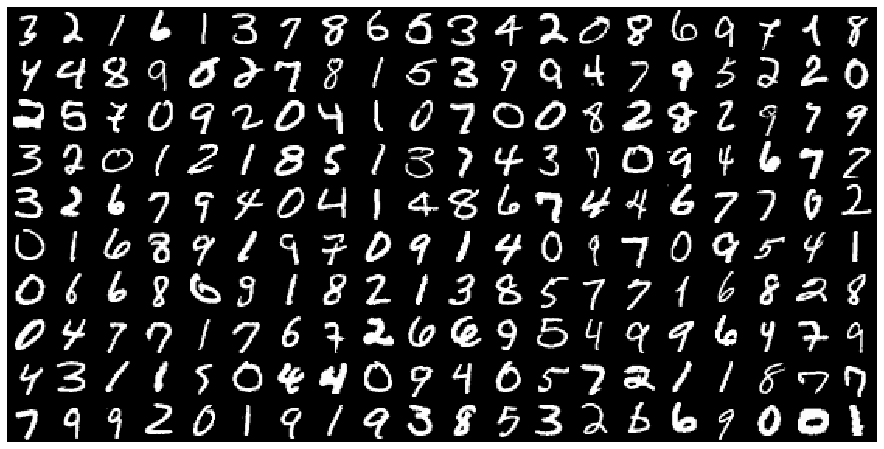

In [0]:
show_linearized_images_sample(numbers_X)


create and train an RBM with 100 components, batch_size 5, learning_rate 0.1 and 100 iterations with `numbers_X`

In [0]:
from sklearn.neural_network import BernoulliRBM

rbm = BernoulliRBM(n_components=100, batch_size=5, learning_rate=.1,n_iter=100, random_state=None, verbose=0)
rbm.fit(numbers_X);

### obtain the `W` matrix and plot the 100 components from the trained RBM (matrix `W`)

you should see something approximately like this


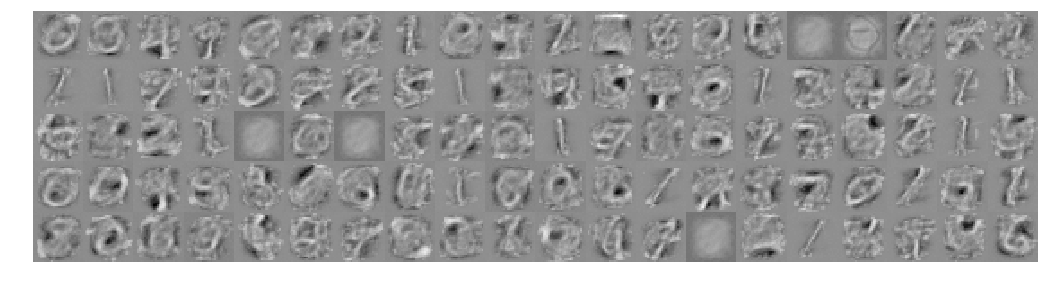

In [0]:
Image(filename='local/imgs/lab_rbm_components.png')

In [0]:
c, b, W = rbm.intercept_visible_, rbm.intercept_hidden_, rbm.components_

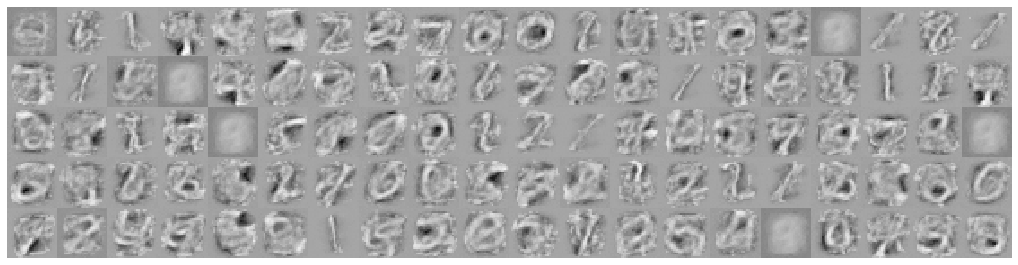

In [0]:
show_linearized_images_sample(W, n_images=len(W))

## Exercise 2

- Load into `fashion_X` 1500 fashion MNIST images and do not forget to normalize their luminosity to the  [0-1] interval.
- Create 1500 random noise images into a variable named `random_imgs` (use `np.random.random(size=(1500,784))`) and set to zero any value under 0.7
- Use the previously trained RBM to compute the free energy of all elements in `fashion_X`, `number_X` , `number_X_sel` and `random_imgs`.
- Plot the histograms. You should see a clear separation of the four datasets.

Your histogram should look roughly like this



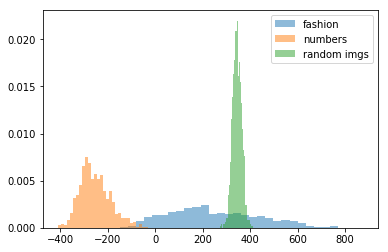

In [0]:
Image(filename='local/imgs/lab_rbm_histograms.png')

In [0]:

from tensorflow.keras import datasets
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()
X_train = x_train.reshape(x_train.shape[0],x_train.shape[1]*x_train.shape[2])
X_test = x_test.reshape(x_test.shape[0],x_test.shape[1]*x_test.shape[2])

(1500, 784)

In [0]:
k = np.random.randint(len(X_train)-1500)
fashion_X  = X_train[k:k+1500]/255
fashion_X.shape

(1500, 784)

In [0]:
random_imgs = np.random.random(size=(1500,784))
random_imgs[random_imgs<0.7]=0
random_imgs.shape


(1500, 784)

In [0]:
def free_energy(v,c,b,W):
    v = v.reshape(-1, v.shape[-1])
    return - v.dot(c)- np.logaddexp(0, v.dot(W.T) + b).sum(axis=1)

In [0]:
rbm.fit(numbers_X);
c, b, W = rbm.intercept_visible_, rbm.intercept_hidden_, rbm.components_
energyNumbers=free_energy(numbers_X,c,b,W)


In [0]:
rbm.fit(fashion_X);
c, b, W = rbm.intercept_visible_, rbm.intercept_hidden_, rbm.components_
energyFashion=free_energy(fashion_X,c,b,W)

In [0]:
rbm.fit(random_imgs);
c, b, W = rbm.intercept_visible_, rbm.intercept_hidden_, rbm.components_
energyRandom=free_energy(random_imgs,c,b,W)

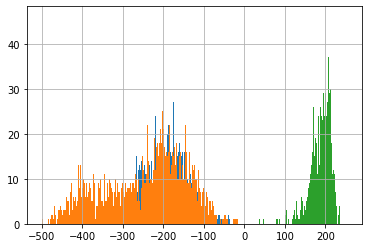

In [0]:
plt.hist(energyNumbers.flatten(),bins=200)
plt.hist(energyFashion.flatten(),bins=200);
plt.hist(energyRandom.flatten(),bins=200);
plt.grid()
plt.show()

In [0]:
plt.hist(...);
plt.hist(...);
plt.hist(...);

plt.legend();

## Exercise 3: 

Select a random set of 40 digits and perform a 100 steps Gibbs sampling for each one of them. 

Follow the example here: https://www.kaggle.com/nicw102168/restricted-boltzmann-machine-rbm-on-mnist

Your generation might look like:



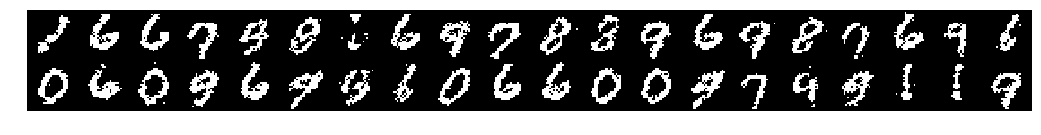

In [0]:
Image(filename='local/imgs/lab_rbm_generated.png')

In [0]:
xx = numbers_X[:40].copy()
xx.shape

In [0]:
for ii in range(100):
    for n in range(40):
        xx[n] = rbm.gibbs(xx[n])

<Figure size 720x1440 with 0 Axes>

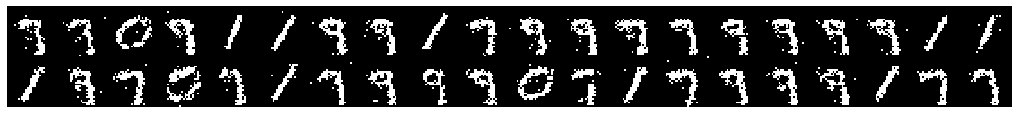

In [0]:
plt.figure(figsize=(10,20))
show_linearized_images_sample(xx, len(xx), permutation=False)

## Exercise 4

Select a simple sklearn classification method (such as GaussianNB or LogisticRegression), make a random train/test split of 50% on MNIST digits and then:

- train and measure the performance of your selected method directly with the raw MNIST data
- train and measure the perofrmance of your selected method **after** transforming MNIST data with the previously trained RBM

you should see some improvement after transforming the data.

In [0]:
from sklearn.model_selection import train_test_split

x_train_number, x_test_number,y_train_number,y_test_number = train_test_split(numbers_X,numbers_y, test_size=0.5, random_state =40)

In [0]:
x_test_number

In [0]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

ClasGauss= GaussianNB()
ClasGauss.fit(x_train_number,y_train_number)

#... create and fit classifier ... 
#... measure performace in train and test ...

GaussianNB(priors=None, var_smoothing=1e-09)

In [0]:
tr_preds=ClasGauss.predict(x_train_number)
ts_preds=ClasGauss.predict(x_test_number)
print("accuracy train %.2f"%ClasGauss.score(x_train_number,y_train_number))

accuracy train 0.75


In [0]:
print("accuracy test %.2f"%ClasGauss.score(x_test_number,y_test_number))

accuracy test 0.61


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.base import clone


rbm_features_classifier = Pipeline(
    steps=[('rbm', rbm), ('ClasGauss', ClasGauss)])

In [0]:
rbm_features_classifier.fit(x_train_number,y_train_number);

In [0]:
from sklearn import  metrics

Y_pred_rbm = rbm_features_classifier.predict(x_test_number)
print("GaussianNB using RBM features:\n%s\n" % (
    metrics.classification_report(y_test_number, Y_pred_rbm)))


GaussianNB using RBM features:
              precision    recall  f1-score   support

           0       0.57      0.91      0.70        69
           1       0.76      0.96      0.85        71
           2       0.62      0.32      0.42        94
           3       0.49      0.61      0.54        71
           4       0.53      0.76      0.62        83
           5       0.52      0.53      0.52        59
           6       0.74      0.50      0.60        80
           7       0.82      0.84      0.83        73
           8       0.63      0.51      0.57        78
           9       0.58      0.35      0.43        72

    accuracy                           0.62       750
   macro avg       0.63      0.63      0.61       750
weighted avg       0.63      0.62      0.60       750




In [0]:
print("accuracy test %.2f"%rbm_features_classifier.score(x_test_number,y_test_number))

accuracy test 0.62


In [0]:
print("GaussianNB features:\n%s\n" % (
    metrics.classification_report(y_test_number, ts_preds)))

GaussianNB features:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        69
           1       0.87      0.92      0.89        71
           2       0.63      0.33      0.43        94
           3       0.53      0.42      0.47        71
           4       0.90      0.42      0.57        83
           5       0.23      0.19      0.21        59
           6       0.62      0.85      0.72        80
           7       0.90      0.73      0.80        73
           8       0.33      0.53      0.40        78
           9       0.56      0.94      0.70        72

    accuracy                           0.61       750
   macro avg       0.64      0.61      0.60       750
weighted avg       0.65      0.61      0.60       750


